<a href="https://colab.research.google.com/github/31Wilson13/ntnu_11302generativeAI/blob/main/%20%20%20%20HW10_week11/%E5%8F%B0%E5%B8%AB%E5%A4%A7_612K0031C_AI%E6%89%80%E7%A2%A9%E4%BA%8C_%E7%B0%A1%E7%85%92%E5%93%B2_%E4%BD%9C%E6%A5%AD%E5%8D%81(week11).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 打造 Stable Diffusion 的 WebUI

### 1. 安裝必要套件

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub gradio --upgrade

In [ ]:
from google.colab import userdata
from huggingface_hub import login

hf_token = userdata.get("HuggingFace")
login(token=hf_token)

In [ ]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import gc
import matplotlib.pyplot as plt
import gradio as gr
import random

### 2. 指定並讀入模型
模型網址：https://huggingface.co/SG161222/Realistic_Vision_V5.1_noVAE

In [ ]:

model_name = "SG161222/Realistic_Vision_V5.1_noVAE"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")

In [ ]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

### 3. 生成的函式

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = []
    negative_prompts = []
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

### 4. 打造 Gradio Web App
使用模型官方建議的negative prompt

In [ ]:
default_enhance = "masterpiece, ultra high quality, intricate skin details, cinematic lighting"
default_negative = "(deformed iris, deformed pupils, semi-realistic, cgi, 3d, render, sketch, cartoon, drawing, anime:1.4), text, close up, cropped, out of frame, worst quality, low quality, jpeg artifacts, ugly, duplicate, morbid, mutilated, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, blurry, dehydrated, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, fused fingers, too many fingers, long neck"

with gr.Blocks(css=".gradio-container {background-color: #FAFAFA; padding: 20px;} .gr-button {font-size: 18px; background: linear-gradient(to right, #667eea, #764ba2); color: white;}") as demo:
    gr.Markdown("""
    # 🎨 Realistic Vision 互動圖像生成器
    歡迎使用！輸入提示詞、選擇設定，立即生成你的寫實風格作品！
    """)

    with gr.Row():
        with gr.Column(scale=6):
            prompt = gr.Textbox(label="Prompt", placeholder="請輸入你的提示詞 (prompt)", lines=3)
            with gr.Row():
                use_enhance = gr.Checkbox(label="加強 Prompt", value=True)
                enhance_text = gr.Textbox(label="加強內容", value=default_enhance)
            with gr.Row():
                use_negative = gr.Checkbox(label="使用 Negative Prompt", value=True)
                negative_text = gr.Textbox(label="Negative Prompt 內容", value=default_negative)
            with gr.Row():
                use_custom_seed = gr.Checkbox(label="自訂 Random Seed", value=False)
                custom_seed = gr.Number(label="指定 seed (選填)", value=42)
            with gr.Row():
                height = gr.Dropdown(["512", "768", "1024"], label="高度 Height", value="512")
                width = gr.Dropdown(["512", "768", "1024"], label="寬度 Width", value="512")
            with gr.Row():
                steps = gr.Slider(10, 50, value=20, step=5, label="生成步數 (Steps)")
                num_images = gr.Slider(1, 4, step=1, value=1, label="生成張數")
            generate_btn = gr.Button("🚀 開始生成！")

        with gr.Column(scale=6):
            gallery = gr.Gallery(label="生成結果", columns=2, object_fit="contain", height="auto")
            seed_info = gr.Label(label="使用的 Random Seeds")

    generate_btn.click(
        fn=generate_images,
        inputs=[prompt, use_enhance, enhance_text, use_negative, negative_text,
                use_custom_seed, custom_seed, height, width, steps, num_images],
        outputs=[gallery, seed_info]
    )

In [ ]:
demo.launch(share=True, debug=True)

 ## 生成範例

 1. 在天空中飛行的驢子
 - prompt : A flying donkey wearing sunglasses, mid-air against a clear blue sky, whimsical and surreal style
 - steps : 35
 - size : 768 x 512

 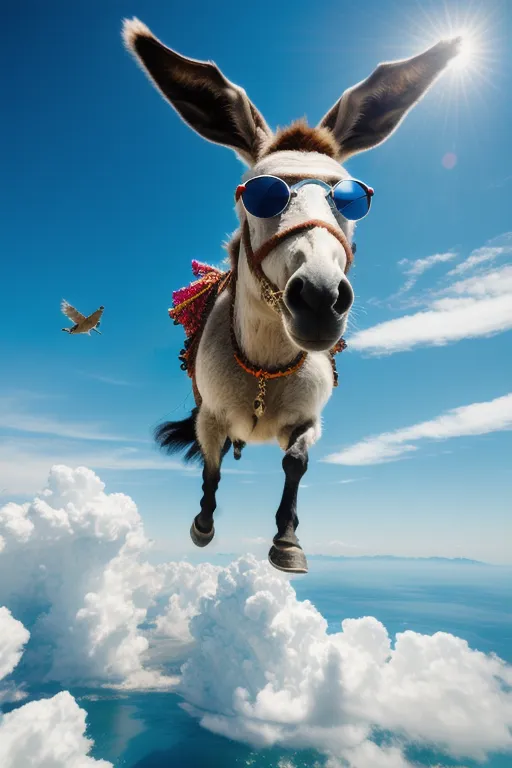

 2. 功夫熊貓（正在練習功夫的熊貓）
 - prompt : A panda practicing Chinese kung fu in a bamboo forest, striking a dynamic martial arts pose, surrounded by tall green bamboo, serene yet powerful atmosphere, traditional Eastern style
 - steps : 35
 - size : 768 x 512

 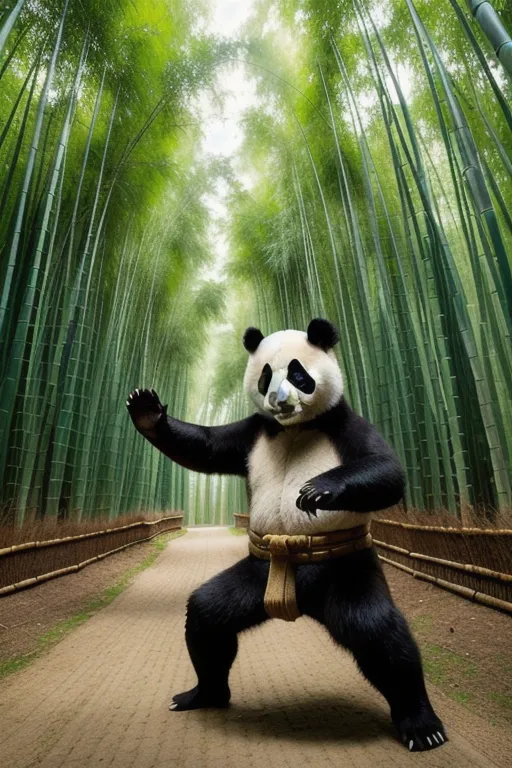

 3. 料理鼠王（正在烹飪的白老鼠）
 - prompt : A clean and cute mouse cooking food in a kitchen, standing on a countertop with tiny utensils and ingredients, cheerful and cozy atmosphere, wholesome cartoon style
 - steps : 35
 - size : 768 x 512

 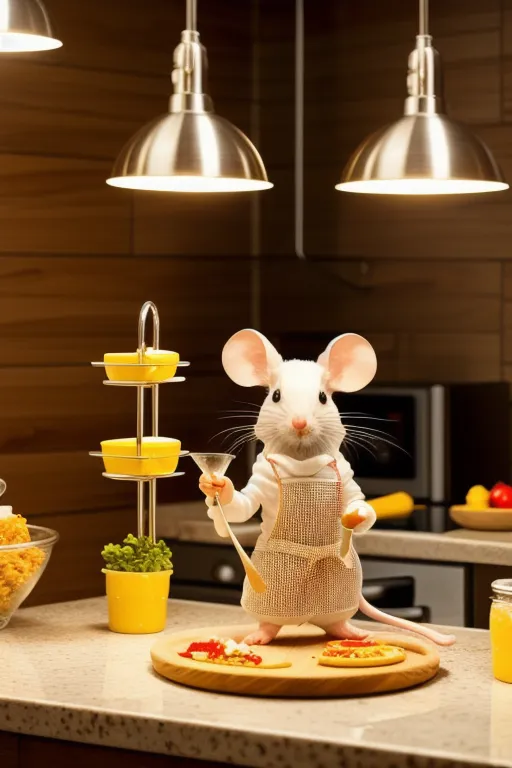

 4. 袋鼠拳擊手
 - prompt : A kangaroo wearing sunglasses and red boxing gloves, training by punching a punching bag in an indoor gym, athletic and energetic atmosphere, comical yet powerful pose
 - steps : 35
 - size : 768 x 512

 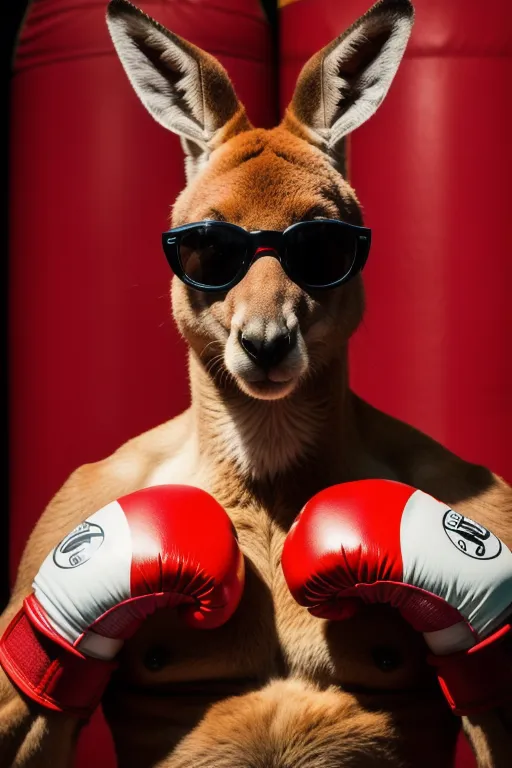